In [8]:
# #############################
# #### Run only first time ####
# #############################
install.packages(c("ape","matlab","rJava","devtools","simecol","abc", "fields","robustHD"))
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("timescape")

## To install cloneid, follow instructions at https://github.com/noemiandor/cloneid
## You will need mysql client: https://dev.mysql.com/downloads/workbench/
# export PATH=$PATH:/Applications/MySQLWorkbench.app/Contents/MacOS

## Download data used in: Andor, N.*, Lau, B., Catalanotti, C., Kumar, V., Sathe, A., Belhocine, K., Wheeler, T., et al. Joint single cell DNA-Seq and RNA-Seq of gastric cancer reveals subclonal signatures of genomic instability and gene expression.
# wget https://dna-discovery.stanford.edu/research/web-resources/CLONEID_gastricCLdata_NAR.sql

## Load data into local mysql database
# mysqldump --column-statistics=0  --host=localhost --port=3306  --user=root -p CLONEID > ~/Downloads/CLONEID_V6_20190812_NAR.sql

## Configure cloneid:
library("cloneid")
editCloneidConfig(host='localhost',  user='USERNAME', password='PASS')
# #############################
# #############################

In [2]:
library("timescape")
library(ape)
library(matlab)
library("cloneid")

In [3]:
## Abbreviations
DNA = "GenomePerspective"
RNA = "TranscriptomePerspective"

## Passage number at the time of library prep. for scRNA- and scDNA-Seq
passages = list()
passages[["SNU-668"]] = list(TranscriptomePerspective = 2, GenomePerspective = 9)
passages[["SNU-16"]] = list(TranscriptomePerspective = 2, GenomePerspective = 7)

Warning message:
“Closing open result sets”Warning message:
“Closing open result sets”Warning message:
“Closing open result sets”Warning message:
“Closing open result sets”

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

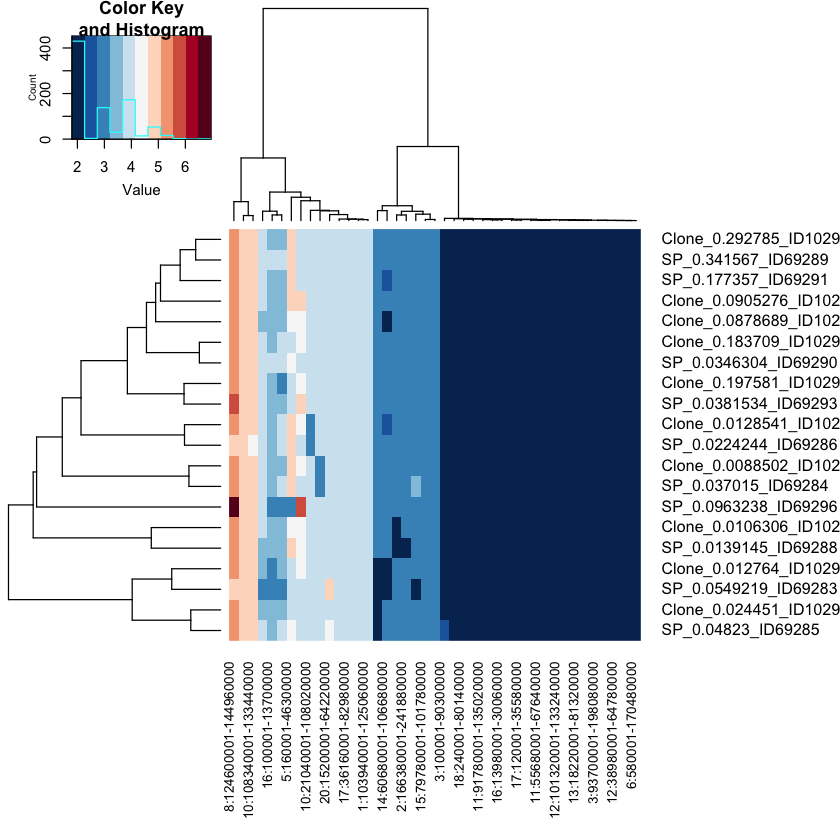

[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Java-Object{Clone_1.0_ID0}"


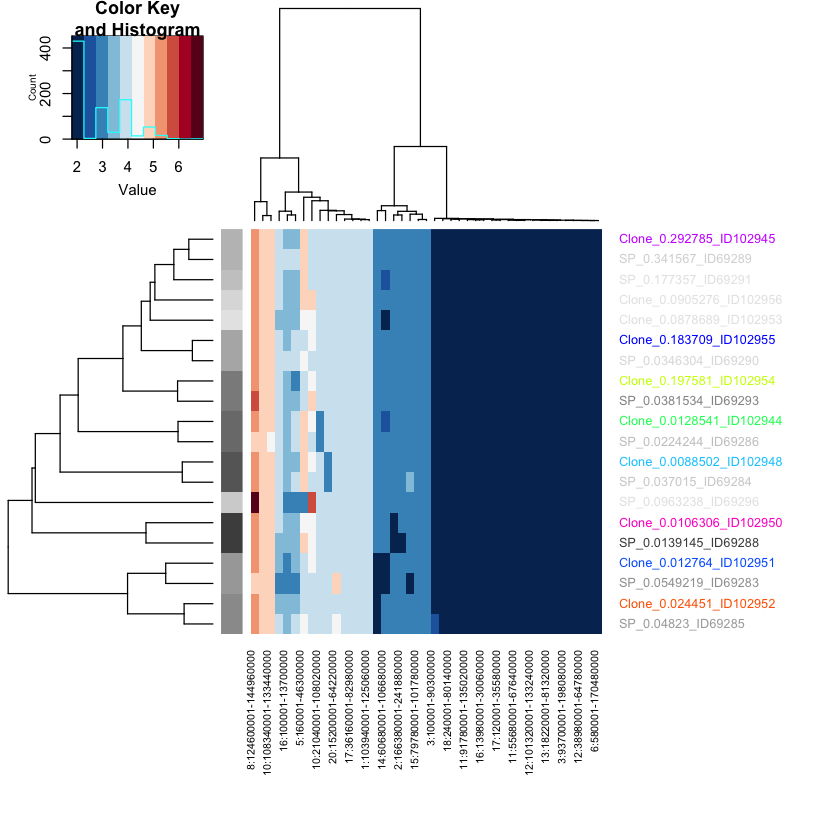

In [27]:
## Trace evolution of coexisting cancer clones within cell line SNU-668 over time
sName = "SNU-668"

## scRNA-seq derived clone profiles
clones_r = cloneid::getSubProfiles(sName, whichP = RNA)
## scDNA-seq derived clone profiles
clones_d = cloneid::getSubProfiles(sName, whichP = DNA)

## Align clones detected with scDNA- and scRNA-seq
try(lapply( dbListConnections( dbDriver( drv = "MySQL")), dbDisconnect))
out = cloneid::mergePerspectives(c(RNA, DNA),specimens = sName,simM = "euclidean",t=2)

In [28]:
## Clonal frequencies at each time point
fr_r = cbind(cloneid::getSPsize(colnames(clones_r)), as.numeric(cloneid::extractID(colnames(clones_r))))
fr_d = cbind(cloneid::getSPsize(colnames(clones_d)), as.numeric(cloneid::extractID(colnames(clones_d))))
fr = rbind(cbind(fr_r, passages[[sName]][[RNA]]), cbind(fr_d, passages[[sName]][[DNA]]))
colnames(fr) = c("clonal_prev", "perspective_id", "timepoint")
fr = as.data.frame(fr)
fr$clone_id = NA; 


## Match clones between scDNA- and scRNA-seq perspectives
tmp = as.data.frame(apply(out$sp2clone, 1, cloneid::extractID))
tmp = tmp[c(DNA,RNA),]
for(cl in colnames(tmp)){
    tmp[,cl] = as.numeric(as.character(tmp[,cl]))
    fr$clone_id[fr$perspective_id %in% tmp[,cl]] = tmp[1,cl];
}
colnames(clones_d) = cloneid::extractID(colnames(clones_d)) 
colnames(clones_r) = cloneid::extractID(colnames(clones_r))
i_r = setdiff(colnames(clones_r), as.character(fr$perspective_id[!is.na(fr$clone_id)]) )
clones = cbind(clones_d[rownames(out$consdat), ], clones_r[rownames(out$consdat), i_r])
fr$clone_id[is.na(fr$clone_id)] = fr$perspective_id[is.na(fr$clone_id)]

In [29]:
## Estimate phyolegentic relations among all clones
tree = ape::bionjs(dist(t(clones)))

In [30]:
## Formatting: Replace leaf ids with tip labels:
tree$tip.label = cloneid::extractID(tree$tip.label)
ii = which(tree$edge[, 2] <= length(tree$tip.label))
tree$edge[ii, 2] = as.numeric(tree$tip.label[tree$edge[ii, 2]])
tree = as.data.frame(tree$edge)
colnames(tree) = c("source", "target")

In [31]:
## Visualization using timescape:
timescape::timescape(clonal_prev = fr[,c("clonal_prev", "clone_id", "timepoint")], tree_edges = tree)

HTML widgets cannot be represented in plain text (need html)